In [541]:
# Imports
import pandas as pd
import math
import time 
import numpy as np
import mrmr

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns

In [542]:
# Constants
DATA_PATH = 'NewGeneratedData/'
MODELS_PATH = 'Models/'

BATCH_SIZE = 64
EPOCHS = 100

EARLY_STOP = False
EARLY_STOP_LEN = 5

RECORD = True     
model_name = "cnn_21"

NUM_FEATURES = 30
FEATURE_SELECTOR = "mrmr"

In [543]:
# Loading functions
def load_data_frame(txt):
    return pd.read_csv(DATA_PATH + txt + '.txt', header=None, sep='\s+')

In [544]:
FEATURES = load_data_frame("features")[0].to_list()

complete_set = load_data_frame("har_dataset")
complete_set.columns = FEATURES
train_set, test_set = train_test_split(complete_set, test_size=0.3, random_state=37)

train_set['activity'] = train_set['activity'].astype(int) - 1
test_set['activity'] = test_set['activity'].astype(int) - 1

activity_labels = load_data_frame('activity_labels')
activity_labels.columns = ['id', 'activity']
activity_labels['activity'] = activity_labels['id'].astype(int) - 1

In [545]:
# Creating model
device = None

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

class OurModel(nn.Module):
    def __init__(self):
        super(OurModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=NUM_FEATURES, out_features=1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=128, out_features=12),
            nn.ReLU(),
            nn.BatchNorm1d(12),
            nn.Dropout(p=0.5),
            
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

In [546]:
model = OurModel().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [547]:
# Training and testing function
def train(dataloader, model, loss_fn, optimizer):
    # Get batch num
    num_batches = len(dataloader.dataset) / BATCH_SIZE
    i = 0

    # Set the model to train mode
    model.train()

    # For early stopping
    tracking_prev_loss = []

    for batch, (X, y) in enumerate(dataloader):
        # X = X.unsqueeze(-1)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (EARLY_STOP):
            if len(tracking_prev_loss) == 0: 
                tracking_prev_loss.append(loss.item())
            else:
                if tracking_prev_loss[-1] >= loss.item():
                    tracking_prev_loss.append(loss.item())
                    if len(tracking_prev_loss) == EARLY_STOP_LEN:
                        return
                else:
                    tracking_prev_loss = []

        i += 1
        if batch % 50 == 0:
            print(f"loss: {loss.item()}, batch: {i} out of {math.ceil(num_batches)}")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    true_labels, pred_labels = [], []

    with torch.no_grad():
        for X, y in dataloader:
            # X = X.unsqueeze(-1)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            true_labels.extend(y.tolist())
            pred_labels.extend(pred.argmax(1).tolist())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    return (f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"), confusion_matrix(true_labels, pred_labels)

In [548]:
# Dataset preparation
class HAPTDataset(Dataset):
    def __init__(self, dataset, features, label):
        self.data = torch.tensor(dataset[features].values, dtype=torch.float32)
        self.labels = torch.tensor(dataset[label].values, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
mrmr_selected_features = mrmr.mrmr_classif(complete_set[complete_set.columns[:-1]], complete_set['activity'], NUM_FEATURES)
train_feature_selected = train_set[mrmr_selected_features]
test_feature_selected = test_set[mrmr_selected_features]

    
train_dataset = HAPTDataset(train_set, mrmr_selected_features, 'activity')
test_dataset = HAPTDataset(test_set, mrmr_selected_features, 'activity')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 30/30 [00:05<00:00,  5.35it/s]


In [549]:
perf_timer = time.perf_counter()
perf_acc, conf_matrix = None, None
perf_list = []

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_function, optimizer)
    perf_acc, conf_matrix = test(test_dataloader, model, loss_function)
    perf_list.append(perf_acc)

print(perf_acc)
perf_timer = time.perf_counter() - perf_timer
conf_matrix = 100 * conf_matrix.astype('float')/ conf_matrix.sum(axis=1)[:, np.newaxis]
print("Done!")

Epoch 1
-------------------------------
loss: 2.5024969577789307, batch: 1 out of 120
loss: 2.4507875442504883, batch: 51 out of 120
loss: 2.3999571800231934, batch: 101 out of 120
Epoch 2
-------------------------------
loss: 2.461456298828125, batch: 1 out of 120
loss: 2.421006202697754, batch: 51 out of 120
loss: 2.4047155380249023, batch: 101 out of 120
Epoch 3
-------------------------------
loss: 2.356813430786133, batch: 1 out of 120
loss: 2.367280960083008, batch: 51 out of 120
loss: 2.3732998371124268, batch: 101 out of 120
Epoch 4
-------------------------------
loss: 2.3701412677764893, batch: 1 out of 120
loss: 2.3771438598632812, batch: 51 out of 120
loss: 2.349682092666626, batch: 101 out of 120
Epoch 5
-------------------------------
loss: 2.2888121604919434, batch: 1 out of 120
loss: 2.377593517303467, batch: 51 out of 120
loss: 2.2788424491882324, batch: 101 out of 120
Epoch 6
-------------------------------
loss: 2.300243854522705, batch: 1 out of 120
loss: 2.33707284

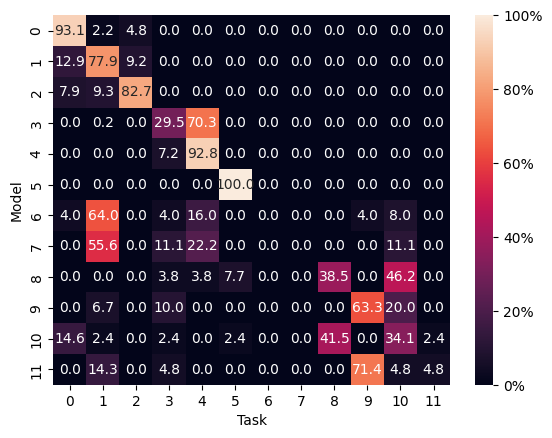

In [550]:
plot = sns.heatmap(conf_matrix, annot=True, fmt=".1f", cbar_kws={'format': '%.0f%%'}, xticklabels=activity_labels.activity, yticklabels=activity_labels.activity)
plot.set_xlabel("Task")
plot.set_ylabel("Model")

if RECORD:
    torch.save(model.state_dict(), MODELS_PATH + model_name + ".pth")

    with open(MODELS_PATH + model_name + ".txt", "w") as f:
        f.write("Epochs: {}\n".format(EPOCHS))
        f.write("Feature Selection: {}\n".format(FEATURE_SELECTOR))
        f.write("Feature Set: {}\n".format(FEATURES))
        f.write("Model: {}\n".format(str(model)))
        f.write("Loss Function: {}\n".format("Cross Entropy Loss"))
        f.write("Optimizer: {}\n\n\n\n".format(str(optimizer)))
        f.write("Results: {}\n".format(perf_acc))
        f.write("Timer: {}s\n".format(round(perf_timer, 2)))
        f.close()

    plot.get_figure().savefig(MODELS_PATH + model_name + "_matrix.png")